In [15]:
import sys
sys.path.append('py_scripts')
import helper_functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
df = pd.read_csv("500_Person_Gender_Height_Weight_Index.csv")

## Dataset Description

- Gender : Male / Female
- Height : Number (cm)
- Weight : Number (Kg)
- Index  : Fitness

|Index|Fitness|
|-|-|
|0|Extremely Weak|
|1|Weak|
|2|Normal|
|3|Overweight|
|4|Obesity|
|5|Extreme Obesity|

## Data Cleaning
- rename columns

In [17]:
df = df.rename(columns={'Gender': 'sex', 'Height': 'height_cm', 'Weight': 'weight_kg', 'Index': 'index'})

## Feature Engineer
- Convert Metric to Imperial

In [18]:
df['height_in'] = round((df['height_cm']/2.54),0)
df['weight_lbs'] = round((df['weight_kg']*2.205),2)

- Calculate BMI
\begin{align}
\ BMI = \frac{weight(kg)}{height(m)^2}
\end{align}

In [19]:
df['BMI'] = round(df['weight_kg']/((df['height_cm']/100)**2), 2)

In [20]:
df = df.drop(['height_cm', 'weight_kg'], axis=1)
df

,sex,index,height_in,weight_lbs,BMI
0,Male,4,69.0,211.68,31.71
1,Male,2,74.0,191.84,24.36
2,Female,4,73.0,242.55,32.14
3,Female,3,77.0,229.32,27.35
4,Male,3,59.0,134.50,27.48
...,...,...,...,...,...
495,Female,5,59.0,337.36,68.00
496,Female,4,72.0,266.80,35.74
497,Female,5,56.0,299.88,68.41
498,Male,5,59.0,209.48,42.22


In [21]:
df.head()

,sex,index,height_in,weight_lbs,BMI
0,Male,4,69.0,211.68,31.71
1,Male,2,74.0,191.84,24.36
2,Female,4,73.0,242.55,32.14
3,Female,3,77.0,229.32,27.35
4,Male,3,59.0,134.50,27.48


In [22]:
df.dtypes

sex            object
index           int64
height_in     float64
weight_lbs    float64
BMI           float64
dtype: object

In [23]:
df.describe()

,index,height_in,weight_lbs,BMI
count,500.000000,500.000000,500.000000,500.00000
mean,3.748000,66.920000,233.730780,37.76572
std,1.355053,6.460734,71.403903,13.96555
min,0.000000,55.000000,110.250000,12.75000
25%,3.000000,61.000000,176.400000,27.16750
50%,4.000000,67.000000,233.730000,36.95500
75%,5.000000,72.000000,299.880000,46.38750
max,5.000000,78.000000,352.800000,78.85000


In [24]:
df['sex'] = df['sex'].replace(['Male'], 0)
df['sex'] = df['sex'].replace(['Female'], 1)

In [25]:
df.head()

,sex,index,height_in,weight_lbs,BMI
0,0,4,69.0,211.68,31.71
1,0,2,74.0,191.84,24.36
2,1,4,73.0,242.55,32.14
3,1,3,77.0,229.32,27.35
4,0,3,59.0,134.50,27.48


### Alternate Method using Map
 - note: when using True False, it's usually True 1 and False 0

In [12]:
sex_map = { 'Male' : 0, 'Female' : 1}

In [13]:
df['sex'] = df['sex'].map(sex_map)

In [14]:
df.head()

,sex,index,height_in,weight_lbs,BMI
0,0,4,69.0,211.68,31.71
1,0,2,74.0,191.84,24.36
2,1,4,73.0,242.55,32.14
3,1,3,77.0,229.32,27.35
4,0,3,59.0,134.50,27.48


Target Variable
sex
0    245
1    255
Name: sex, dtype: int64


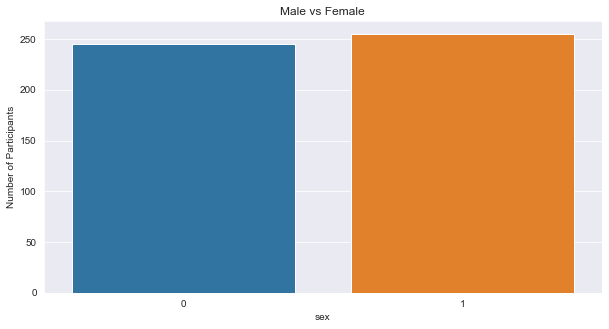

In [11]:
print('Target Variable')
print(df.groupby(['sex']).sex.count())

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['sex'])
plt.title('Male vs Female')
plt.ylabel('Number of Participants')
plt.show()

In [12]:
X = df.loc[:, 'index':'BMI']
y = df['sex']

## Split into training and test set

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

## Dummy Classifier

In [59]:
model_dummy = DummyClassifier(strategy="uniform", random_state=1)
model_dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=1, strategy='uniform')

In [60]:
y_predict_dummy = model_dummy.predict(X_test)
print(f'Baseline Accuracy Score: {accuracy_score(y_test, y_predict_dummy) * 100:.2f}%')
print(f'Baseline Precision Score: {precision_score(y_test, y_predict_dummy) * 100:.2f}%')

Baseline Accuracy Score: 57.00%
Baseline Precision Score: 58.18%


In [61]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_dummy),
    columns=['Predicted Male', 'Predicted Female'],
    index=['True Male', 'True Female']
)

,Predicted Male,Predicted Female
True Male,25,23
True Female,20,32


Confusion Matrix, without normalization
[[25 23]
 [20 32]]


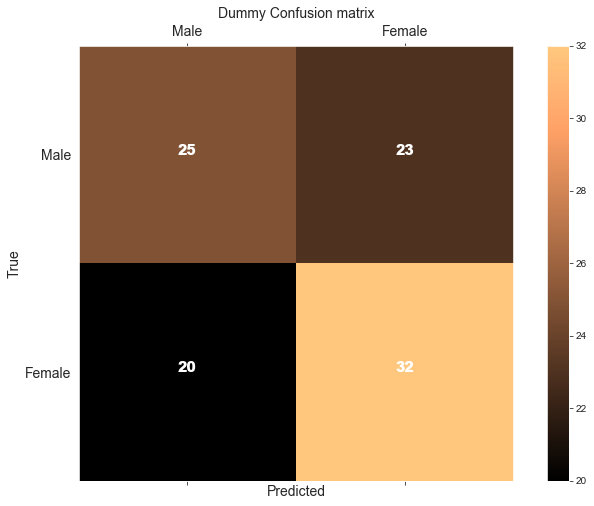

In [62]:
classes = ['Male','Female']
cm_dummy = confusion_matrix(y_test, y_predict_dummy)
helper_functions.plot_confusion_matrix(cm_dummy, classes, title='Dummy Confusion matrix', cmap=plt.cm.copper)

In [63]:
print(classification_report(y_test, y_predict_dummy))

              precision    recall  f1-score   support

           0       0.56      0.52      0.54        48
           1       0.58      0.62      0.60        52

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100



In [19]:
cr_dummy = classification_report(y_test, y_predict_dummy, output_dict=True)
df_cr_dummy = pd.DataFrame(cr_dummy).transpose()
df_cr_dummy

,precision,recall,f1-score,support
0,0.555556,0.520833,0.537634,48.00
1,0.581818,0.615385,0.598131,52.00
accuracy,0.570000,0.570000,0.570000,0.57
macro avg,0.568687,0.568109,0.567883,100.00
weighted avg,0.569212,0.570000,0.569093,100.00


## Decision Tree

In [201]:
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [202]:
y_predict_decision_tree = model_decision_tree.predict(X_test)
accuracy_score(y_test, y_predict_decision_tree)

0.52

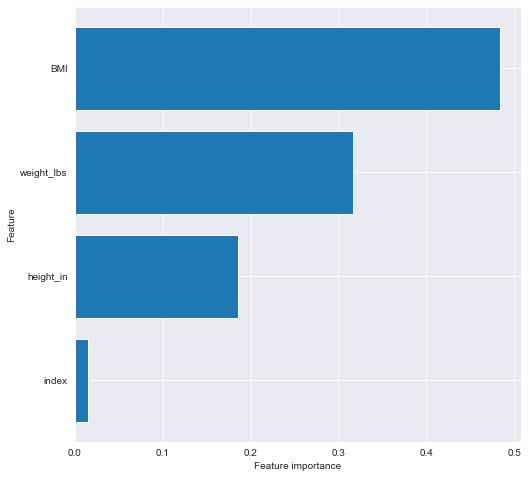

In [203]:
helper_functions.plot_feature_importances(model_decision_tree, X_train)

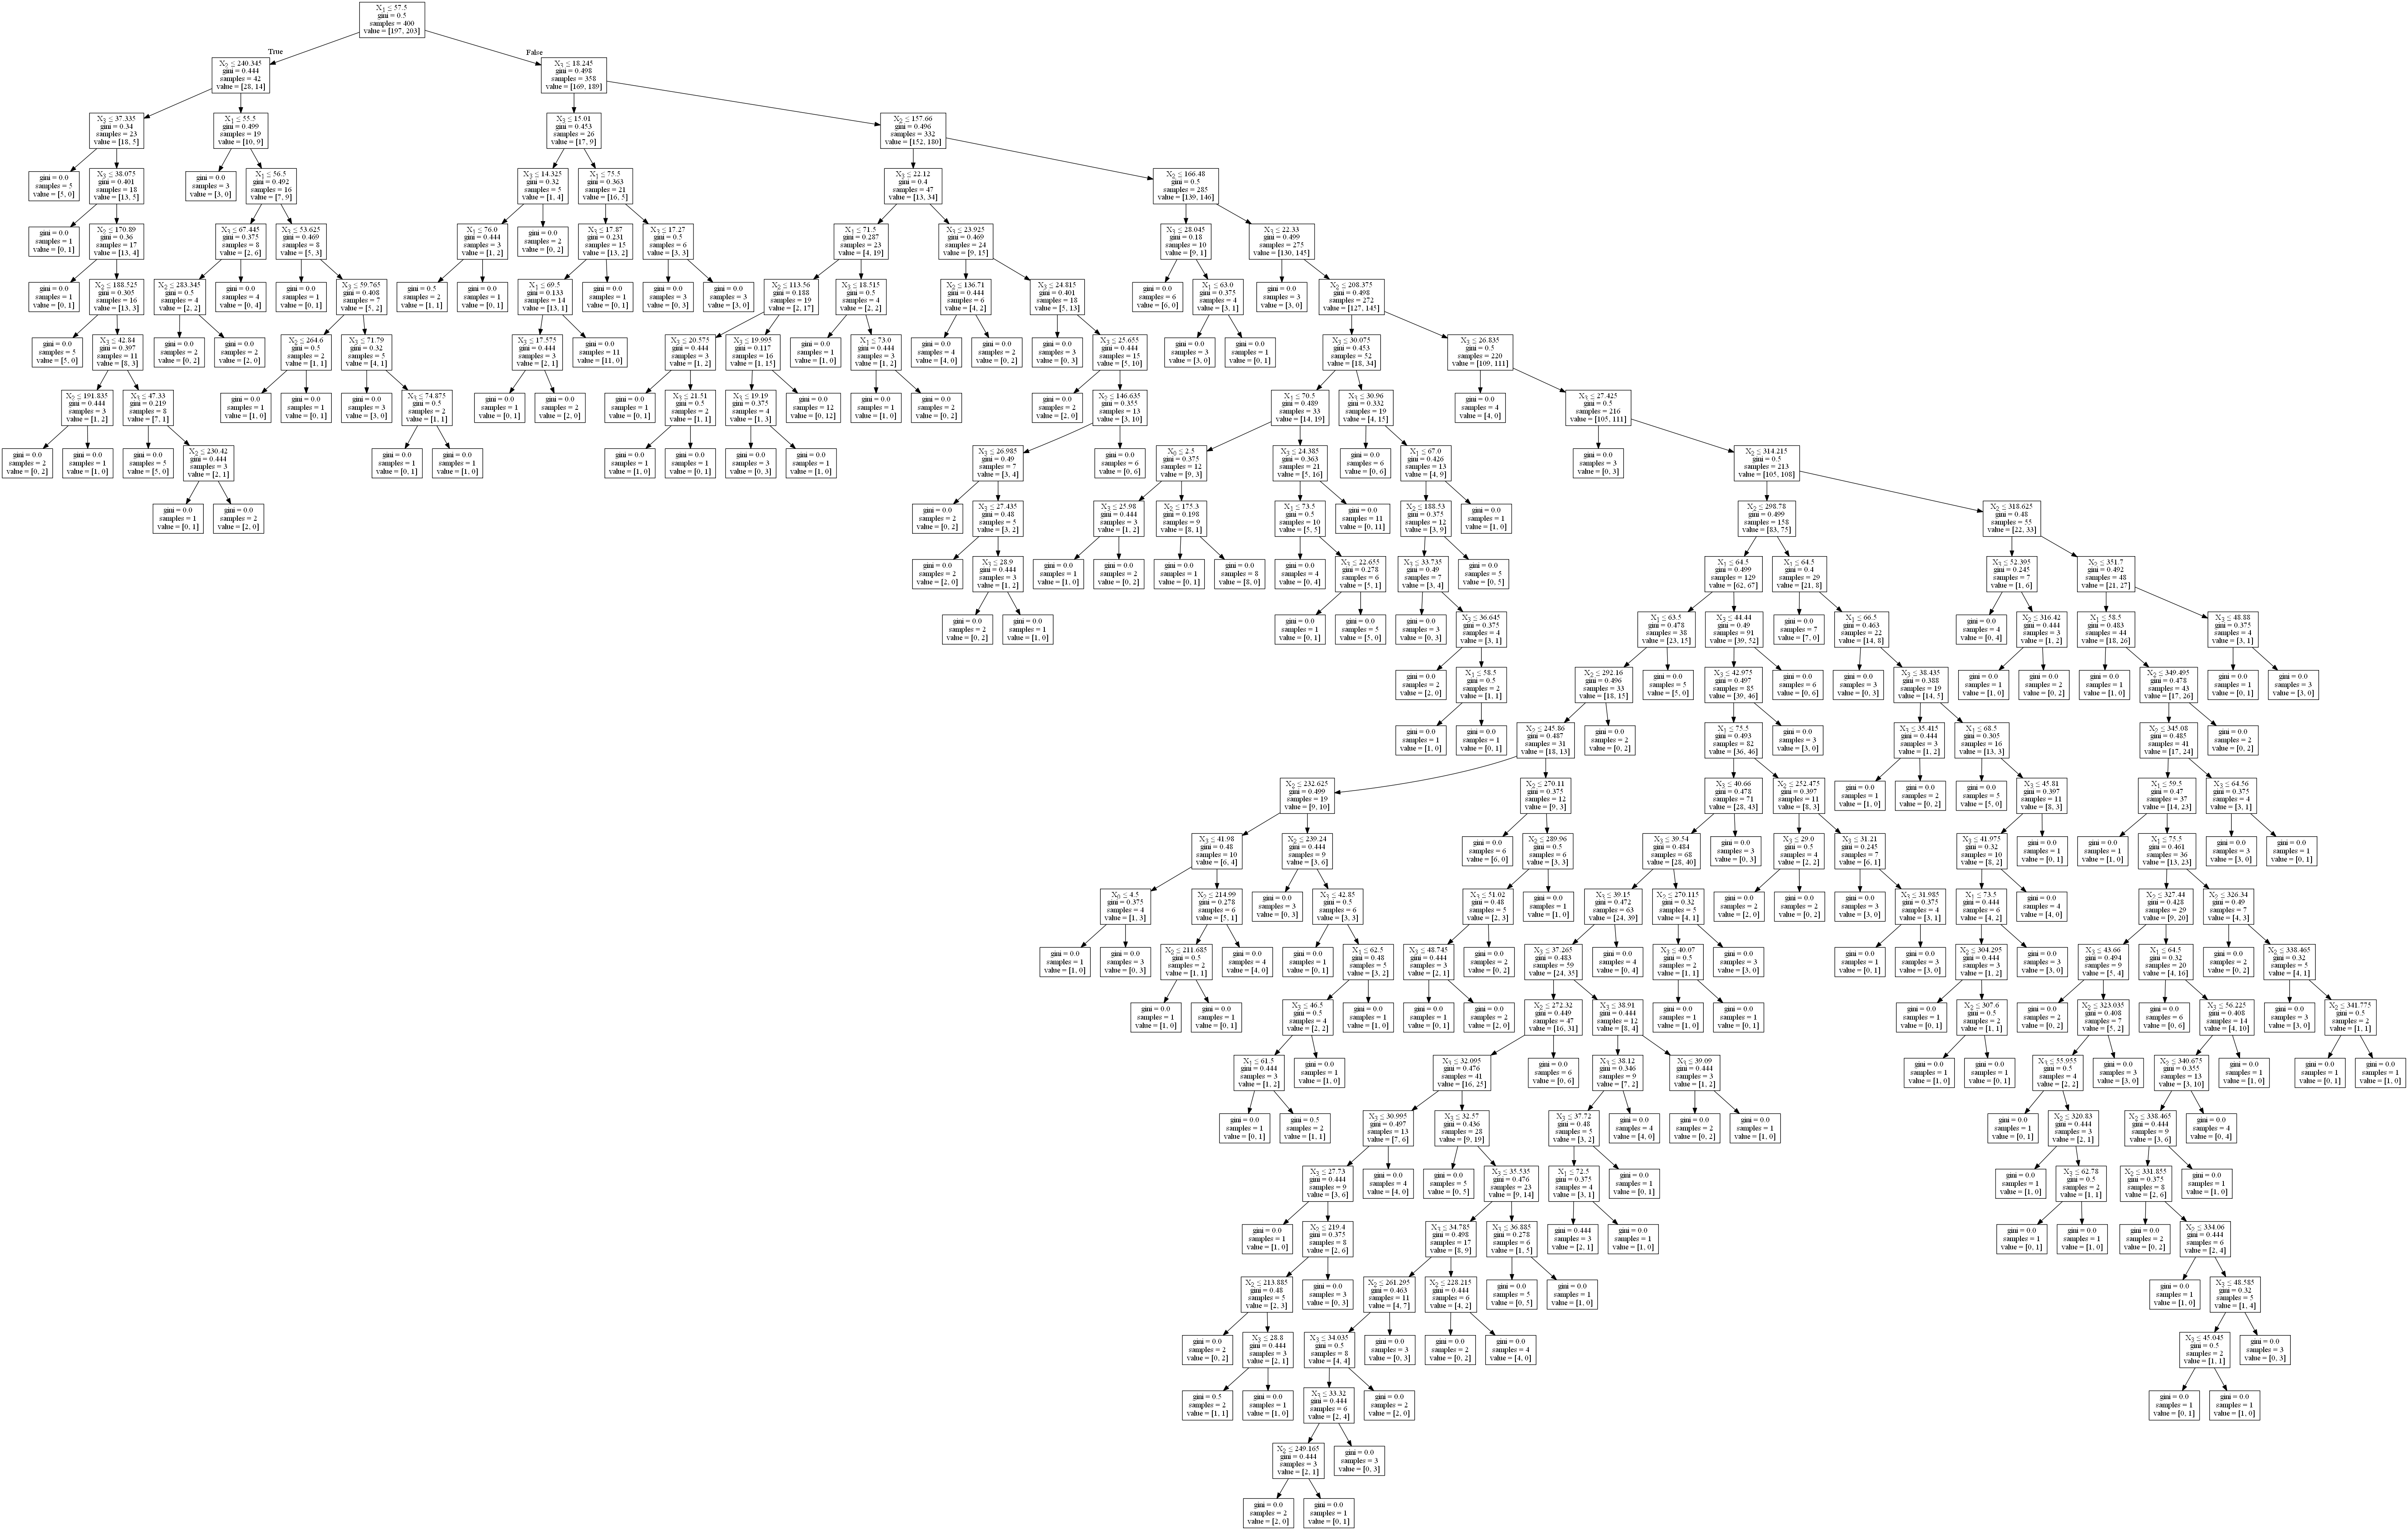

In [204]:
# visualizing the regression tree
dot_data = StringIO()
export_graphviz(model_decision_tree, out_file=dot_data,  
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [205]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_decision_tree),
    columns=['Predicted Male', 'Predicted Female'],
    index=['True Male', 'True Female']
)

,Predicted Male,Predicted Female
True Male,24,24
True Female,24,28


Confusion Matrix, without normalization
[[24 24]
 [24 28]]


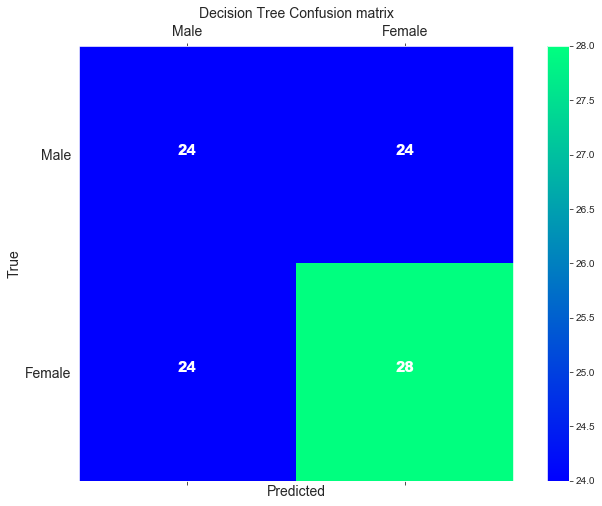

In [206]:
cm_decision_tree = confusion_matrix(y_test, y_predict_decision_tree)
helper_functions.plot_confusion_matrix(cm_decision_tree, classes, title='Decision Tree Confusion matrix', cmap=plt.cm.winter)

In [207]:
print(classification_report(y_test, y_predict_decision_tree))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        48
           1       0.54      0.54      0.54        52

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.52      0.52      0.52       100



In [208]:
cr_decision_tree = classification_report(y_test, y_predict_decision_tree, output_dict=True)
df_cr_decision_tree = pd.DataFrame(cr_decision_tree).transpose()
df_cr_decision_tree

,precision,recall,f1-score,support
0,0.500000,0.500000,0.500000,48.00
1,0.538462,0.538462,0.538462,52.00
accuracy,0.520000,0.520000,0.520000,0.52
macro avg,0.519231,0.519231,0.519231,100.00
weighted avg,0.520000,0.520000,0.520000,100.00


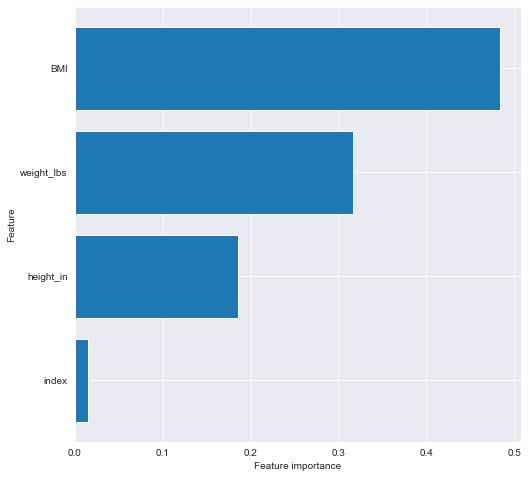

In [209]:
helper_functions.plot_feature_importances(model_decision_tree, X_train)

## Tune Decision Tree

[0.4802020202020202, 0.49383838383838385, 0.47525252525252526, 0.46925252525252525, 0.46220202020202017, 0.45749494949494945, 0.47301010101010105, 0.4516161616161616, 0.46769696969696967, 0.4763434343434343, 0.49195959595959593, 0.4723434343434343, 0.4682424242424241, 0.47424242424242424, 0.48220202020202024, 0.48838383838383825, 0.4918181818181818, 0.49616161616161614, 0.4883838383838384, 0.49997979797979786, 0.4879393939393939, 0.49274747474747477, 0.4921212121212121, 0.5087878787878788, 0.46812121212121205, 0.5031515151515151, 0.485111111111111, 0.48751515151515157, 0.5011919191919192, 0.5011515151515151, 0.48319191919191923, 0.49515151515151506, 0.49133333333333334, 0.4953737373737374, 0.5049292929292929, 0.5068282828282829, 0.5069292929292929, 0.4911515151515151, 0.4911515151515152, 0.5110707070707071, 0.5023434343434343, 0.5054141414141414, 0.49573737373737375, 0.4993737373737373, 0.5077777777777778, 0.4931919191919192, 0.5094141414141413, 0.48656565656565653, 0.5011919191919192]

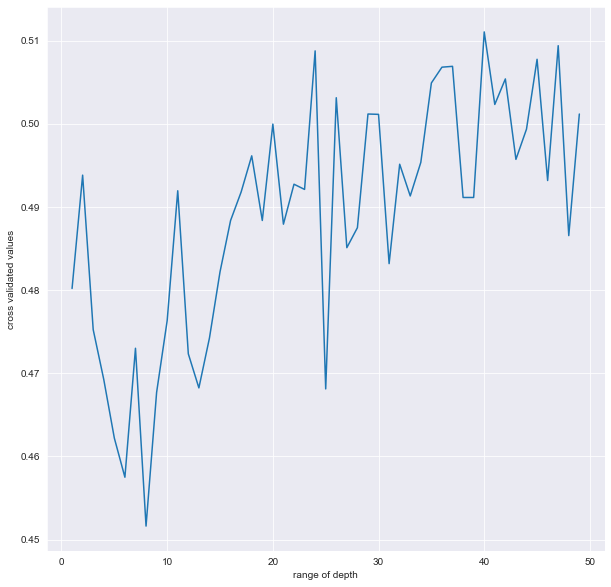

In [188]:
score = cross_val_score(model_decision_tree, X, y, cv = 50)
score.mean()
depth_range = range(1,50)
val = []
for depth in depth_range:
    model_decision_tree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(model_decision_tree, X, y, cv = 50)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()